# Study Case 3 — Chemistry-Only Modeling: Generalization Across Alloy Systems

This notebook operationalizes **Study Case 3 (SC03)** by evaluating whether the chemistry-only modeling framework established in SC02 remains valid when applied to different alloy systems.

The analysis intentionally **reuses the full analytical pipeline from SC02** without methodological changes. By holding the modeling approach constant, any observed differences can be attributed to system-specific metallurgical behavior rather than analytical artifacts.

All results are evaluated under group-aware, out-of-fold validation to reflect generalization to unseen heats.

## Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from portfolio_analytics_toolkit.io import load_public_dataset
from portfolio_analytics_toolkit.cv import build_oof_predictions, summarize_folds, metrics_by_fold
from portfolio_analytics_toolkit.metrics import metrics_from_oof,q_summary,iqr
from portfolio_analytics_toolkit.plots import plot_actual_vs_predicted,plot_residual_hist,plot_p95_abs_error,plot_p95_abs_error_hbar,plot_importance,plot_study_window_histogram,plot_mae_median_cv
from portfolio_analytics_toolkit.importance import compute_permutation_importance, importance_by_fold
from portfolio_analytics_toolkit.style import set_matplotlib_style

set_matplotlib_style('ggplot')

## 0. Executive Framing & Scope

Study Case 3 (SC03) evaluates whether the **chemistry-only modeling framework** established in SC02 generalizes across alloy systems, even if the optimal functional form does not.

The scope of this study is intentionally narrow:
- **Inputs** are limited to Fe and Si to isolate chemistry-driven signal in 1xxx-O systems.
- The **analytical unit** is the heat, consistent with SC02.
- **Validation strategy**, features, and model families are held constant relative to SC02.

SC03 functions as a **generalization test** for the modeling framework, establishing whether chemistry-only approaches remain valid across alloy families before introducing additional variables.

## 1. Analytical Setup & Study Assumptions

The analytical setup is defined to align modeling, validation, and interpretation at heat level.

### Assumptions
- Each heat is treated as an independent analytical unit.
- Bulk chemistry (Fe, Si) acts as a first-order constraint on achievable UTS.
- Aggregated heat-level UTS represents the appropriate decision granularity.
- AA1050-O and AA1100-O are treated as a single "1xxx-O family" to reflect industrial practice.

### Methodological choices
- **Fixed pipeline:** The full SC02 analytical pipeline is reused without modification.
- **Validation:** Group-aware CV at heat level prevents leakage.
- **Models:** Ridge, Polynomial (degree 2), and Random Forest are evaluated under identical conditions.

### Non-goals
- Within-heat variability, process history, and microstructural effects are not modeled.
- Extrapolation beyond the observed chemistry domain is not supported.

## 2. Data Construction & Sanity Checks

Model inputs are constructed with minimal, intentional preprocessing to preserve operational variability.

- The dataset is restricted to required fields only (heat ID, UTS, Fe, Si).
- Data are aggregated to ensure a single record per heat.
- Post-aggregation checks confirm one-to-one correspondence between rows and heats.

Basic distributional summaries are used to verify plausible ranges and coverage of the chemistry and UTS domains.

In [2]:
# -----------------------------
# Study scope
# -----------------------------

N_SPLITS = 5
RANDOM_STATE = 42
RF_ESTIMATORS = 300

ALLOY_SYSTEM = ['1050', '1100']
FEATURE_COLS = ['fe', 'si']
TARGET_COL = 'uts_mpa'
GROUP_COL = 'heat_num'

In [3]:
# -----------------------------
# Pull model data
# -----------------------------

required = ['heat_num', 'uts_mpa', 'fe', 'si']

df = load_public_dataset(
    dataset_id_or_path='sc03',
    csv_name='v_models_analysis_o_1000.csv'
)

df_model = df[required].copy()

print('rows:', len(df_model))
print('heats:', df_model['heat_num'].nunique())

rows: 952
heats: 952


### Heat-Level Integrity Check

A post-aggregation grain check is performed to confirm one-to-one correspondence between heats and model rows. This ensures that validation reflects generalization to unseen heats rather than repeated measurements.

In [4]:
# Grain check (post-merge): one row per heat
rows_per_heat = df_model.groupby('heat_num').size()
rows_per_heat.describe()

count    952.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64

### Distributional Overview

Basic distributional summaries are used to verify plausible ranges and coverage of both chemistry and UTS.

No filtering is applied at this stage, as extreme values are considered representative of operational variability.

In [23]:
display(df_model[FEATURE_COLS].apply(q_summary).round(3).T)
display(df_model[TARGET_COL].pipe(q_summary).to_frame().T)

,min,p01,p50,p99,max
fe,0.070,0.080,0.180,0.490,0.54
si,0.003,0.006,0.063,0.161,0.17


,min,p01,p50,p99,max
0,56.0,61.0,76.0,95.0,102.0


The study window covers Fe ~0.08–0.49 and Si ~0.01–0.16 (p01–p99), with UTS ranging from ~61–95 MPa. This domain differs significantly from AA3105-O in both chemistry nature and mechanical response.

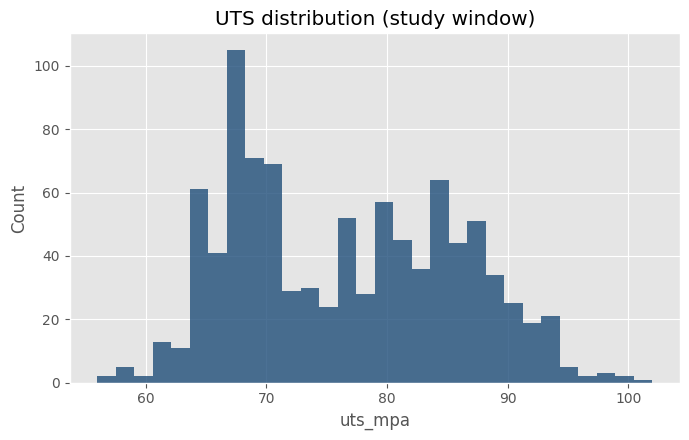

In [6]:
fig, ax = plot_study_window_histogram(df_model, TARGET_COL)

plt.show()

## 3. Problem Definition & Success Criteria

The problem is defined as evaluating whether the **chemistry-only modeling framework** remains valid when applied to a different alloy system, even if the optimal functional form changes.

Success is not defined by maximum predictive accuracy. Instead, the study evaluates whether:
- The framework produces stable performance across validation folds.
- Interpretable relationships remain consistent with metallurgical expectations.
- An error structure can be explicitly characterized and bounded.

Accordingly, evaluation prioritizes **framework generalization** and **error behavior** over marginal improvements in average metrics.

## 4. Baseline Models & Validation Strategy

Three chemistry-only models are evaluated under a shared validation framework:
- **Ridge regression** as the linear, interpretable baseline.
- **Polynomial expansion** with ridge regularization to capture controlled non-linearity.
- **Random Forest** as a diagnostic probe for non-linear signal.

Validation is performed using GroupKFold at heat level, ensuring that all observations from a given heat remain within the same fold.

Out-of-fold predictions are generated for all models and serve as the sole basis for performance metrics and diagnostics. This approach prevents information leakage and ensures that reported errors reflect generalization to unseen heats.

### Baseline Modeling Strategy

With the analytical unit and data integrity established, the following section evaluates a small set of chemistry-only models chosen to balance interpretability, controlled flexibility, and diagnostic coverage.

In [7]:
ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

poly_model = Pipeline([
    ('poly_2', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

rf_model = RandomForestRegressor(
    n_estimators=RF_ESTIMATORS,
    random_state=RANDOM_STATE
)

models = {
    'ridge': ridge_model,
    'poly': poly_model,
    'rf': rf_model
}

### Validation Design

Next, we generate OOF predictions for all models under GroupKFold.

Model evaluation is performed using group-aware cross-validation to prevent information leakage across heats. All reported metrics and diagnostics are computed exclusively from out-of-fold predictions.

In [8]:
oof_df = build_oof_predictions(
    df=df_model,
    models=models,
    feature_cols=FEATURE_COLS,
    target_col='uts_mpa',
    group_col='heat_num',
    n_splits=5,
)

oof_df

,fold,group_id,y_true,y_pred,residual,model_id
0,1,xeiab,82.0,83.471126,-1.471126,poly
1,1,xgdi0,90.0,82.836449,7.163551,poly
2,1,ys8m6,81.0,78.881886,2.118114,poly
3,1,zvg3r,79.0,79.707225,-0.707225,poly
4,1,zwmvk,70.0,79.707225,-9.707225,poly
...,...,...,...,...,...,...
2851,5,3awvg,84.0,84.238461,-0.238461,ridge
2852,5,46tm8,83.0,81.698956,1.301044,ridge
2853,5,48clz,84.0,77.528160,6.471840,ridge
2854,5,4aq5l,75.0,82.078333,-7.078333,ridge


In [9]:
oof_overview = summarize_folds(oof_df)
oof_overview

,fold,val_heats,val_rows
0,1,191,573
1,2,191,573
2,3,190,570
3,4,190,570
4,5,190,570


In [10]:
metrics = metrics_from_oof(oof_df)

## 5. Cross-Validated Performance (Central Metrics)

Model performance is summarized using out-of-fold predictions aggregated across all validation splits.

Central tendency metrics (MAE, RMSE, R²) are reported to provide a baseline comparison between model families. Median values across folds are emphasized to reduce sensitivity to fold-specific variation, with dispersion captured via interquartile range (IQR).

These metrics are used for relative comparison only. They describe average behavior but are not sufficient on their own to support engineering decisions, which depend more strongly on error stability and tail behavior.

In [11]:
metrics_by_fold_df = metrics_by_fold(oof_df)

summary_df = (
    metrics_by_fold_df.groupby('model_id')
    .agg(
        mae_median=('mae', 'median'),
        mae_iqr=('mae', iqr),
        rmse_median=('rmse', 'median'),
        rmse_iqr=('rmse', iqr),
        r2_median=('r2', 'median'),
    )
    .sort_values('mae_median').round(1)
)

summary_df

,mae_median,mae_iqr,rmse_median,rmse_iqr,r2_median
model_id,,,,,
rf,2.0,0.2,2.8,0.5,0.9
poly,2.9,0.2,4.0,0.5,0.8
ridge,3.3,0.3,4.5,0.6,0.8


RF improves median MAE versus linear models, while ridge and poly are nearly indistinguishable on central error.

The near-zero IQR for RF reflects stable performance across folds under a narrow chemistry domain, but should not be overinterpreted as superior robustness.

### Stability Across Validation Folds

Median error and dispersion across folds are examined to assess performance stability and sensitivity to data partitioning.

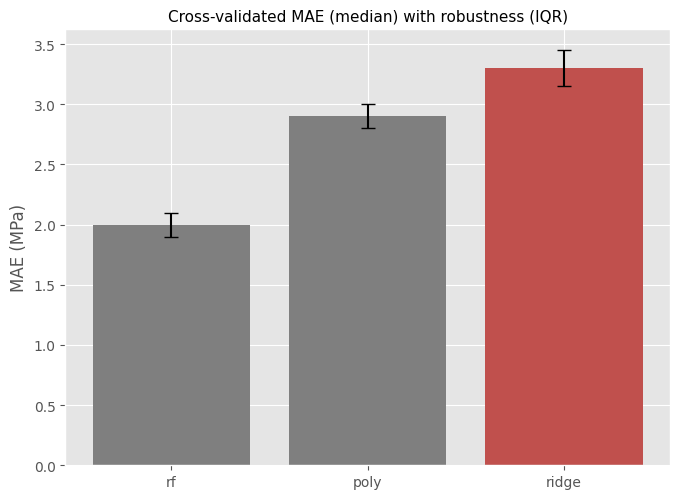

In [12]:
fig, ax = plot_mae_median_cv(summary_df)
plt.show()

In [13]:
# Fold-level performance (transparency check)
fold_metrics_display = (
    metrics_by_fold_df[metrics_by_fold_df['model_id'] == 'ridge']
    [['fold', 'mae', 'rmse', 'r2']]
    .round(2)
)
display(fold_metrics_display)

,fold,mae,rmse,r2
10,1,3.61,5.04,0.72
11,2,3.05,4.31,0.78
12,3,3.15,4.34,0.78
13,4,3.45,4.89,0.72
14,5,3.28,4.49,0.76


While Random Forest shows lower median MAE, its performance advantage should be interpreted with caution. Under a narrow chemistry domain, stable performance across folds does not necessarily imply superior robustness or suitability for deployment.

### Error Behavior Beyond Averages

Average performance metrics do not capture the structure or severity of large deviations. The following diagnostics focus on residual behavior under realistic generalization conditions.

## 6. Error Structure & Tail Risk Diagnostics

Error behavior is evaluated using out-of-fold residuals to assess reliability under realistic generalization conditions.

Residual diagnostics are used to verify that errors are:
- approximately centered,
- reasonably distributed,
- and stable across validation folds.

To explicitly quantify tail risk, the p95 absolute error is computed from out-of-fold predictions. This metric captures large deviations that are more relevant for non-conformance risk than average error measures.

Tail metrics are used to differentiate model robustness where central tendency metrics show limited separation.

### Out-of-Fold Prediction Behavior

Actual versus predicted plots based on out-of-fold data provide a visual check for bias, compression, or systematic deviations.

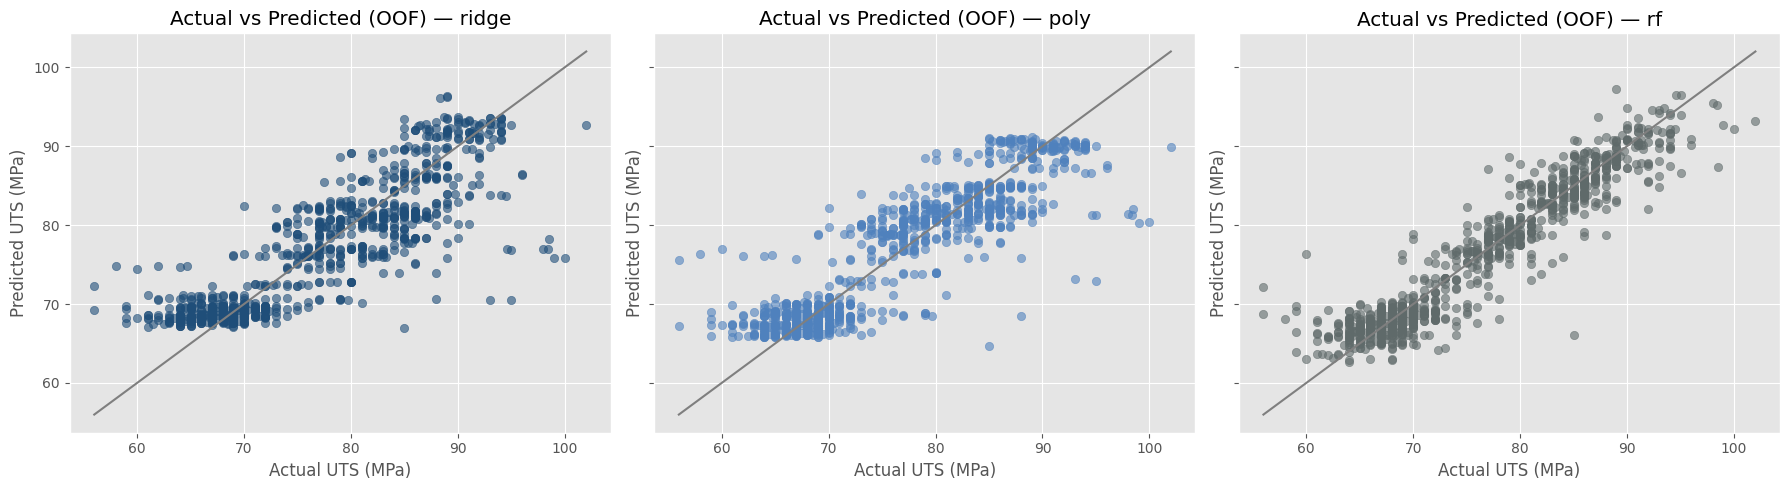

In [14]:
fig, ax = plot_actual_vs_predicted(oof_df, models)

### Residual Distribution Check

Residual distributions are inspected to verify centering and spread, supporting the interpretation of downstream error metrics.

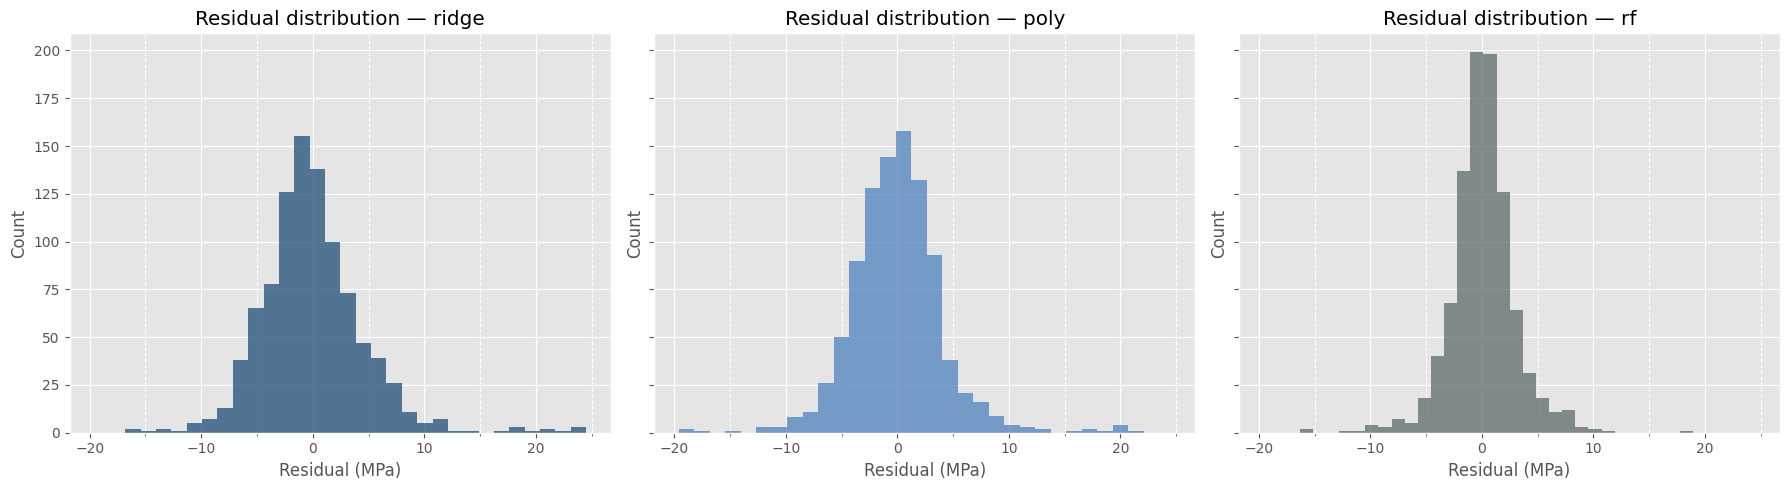

In [15]:
fig, ax = plot_residual_hist(oof_df, models)

### Tail Risk Quantification

High-percentile absolute error is used to explicitly quantify tail risk. This metric captures deviations that drive non-conformance risk and are not visible in average error measures.

For engineering decisions, tail risk is often more relevant than average accuracy.

High-percentile errors capture the magnitude of large, systematic deviations likely to occur in practice. Unlike average metrics, p95 captures the magnitude of large, systematic deviations likely to occur in practice. Differences in p95 reveal robustness gaps that may be invisible when considering median MAE alone.

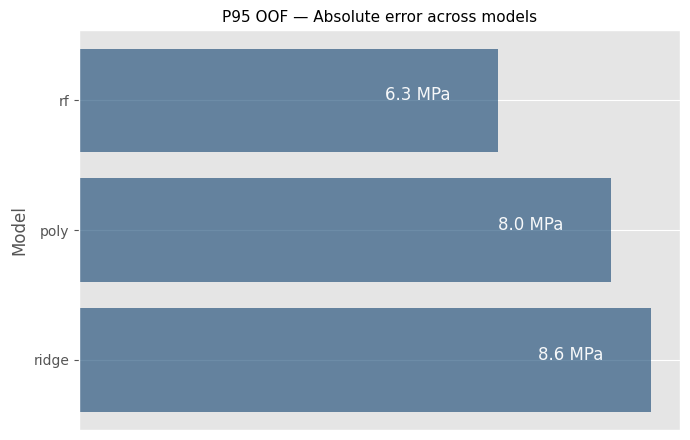

In [16]:
fig, ax = plot_p95_abs_error_hbar(metrics)
plt.show()

Tail risk separates RF from linear families, while ridge and poly remain comparable.

Polynomial models substantially reduce high-percentile error versus linear baselines, capturing non-linear chemistry effects under fixed features and validation.

### Interpretation

- Errors are evaluated using out-of-fold predictions under GroupKFold.
- Residual diagnostics provide a simple reliability check for bias and stability.
- Full uncertainty interval calibration is intentionally deferred to later study cases.

## 7. Interpretability & Metallurgical Plausibility

Interpretability is used as a sanity and trust check, not as exhaustive explainability.

Permutation importance is computed to verify that dominant drivers are:
- stable across models,
- consistent across validation folds,
- and aligned with expected metallurgical influence.

Feature importance results are evaluated for directional plausibility and relative dominance, ensuring that model behavior reflects chemistry-driven effects rather than artifacts of data partitioning or model flexibility.

### Driver dominance across models

In [17]:
imp_test = compute_permutation_importance(
    df=df_model,
    models_dict=models,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL,
)

imp_test

,model_id,feature,importance_mean,importance_std
0,ridge,fe,0.704,0.029
1,ridge,si,0.206,0.012
2,poly,fe,1.609,0.074
3,poly,si,0.070,0.006
4,rf,fe,2.479,0.099
5,rf,si,0.336,0.017


In [18]:
imp_summary = (
    imp_test
    .pivot_table(
        index='feature',
        columns='model_id',
        values='importance_mean',
        aggfunc='mean',
    )
)

imp_summary

model_id,poly,rf,ridge
feature,,,
fe,1.609,2.479,0.704
si,0.070,0.336,0.206


Across all model families, Fe dominates UTS signal, and this dominance is stable across folds.

Si acts as a secondary modifier. This reinforces metallurgical plausibility while revealing system-specific interactions.

### Permutation importance by model

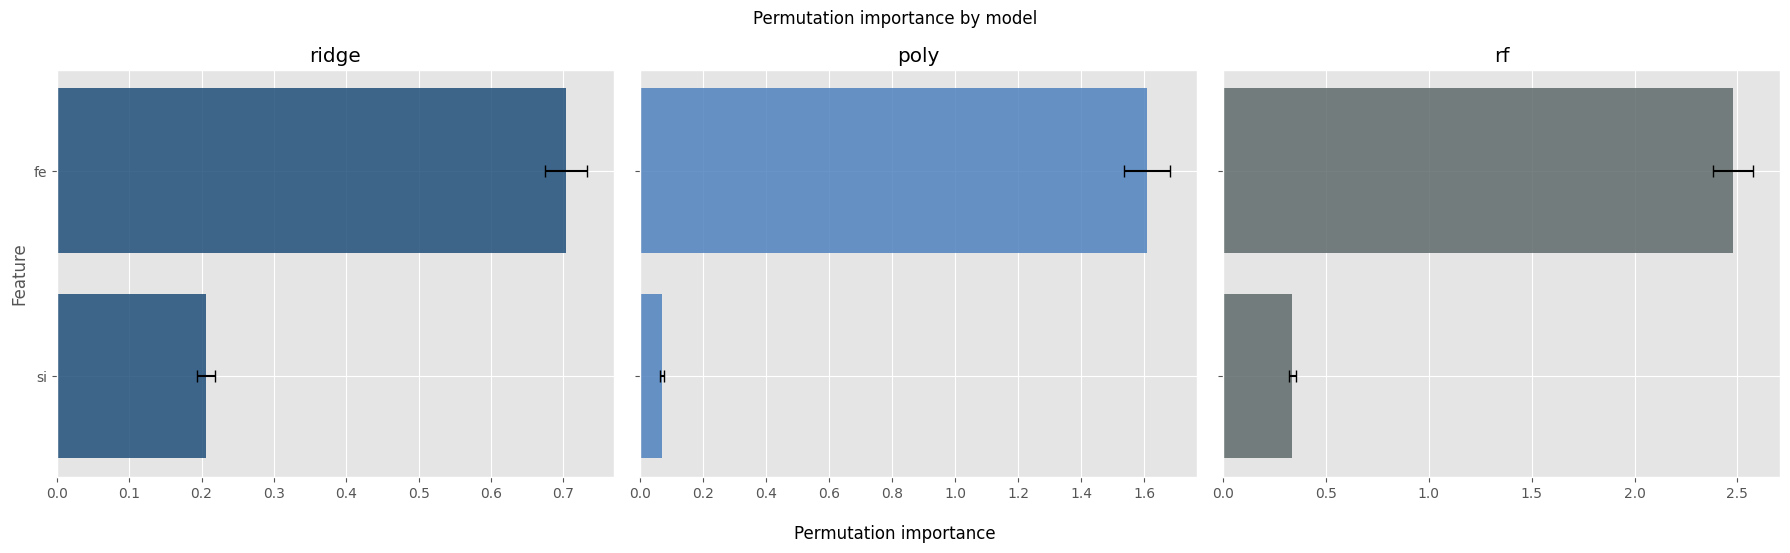

In [19]:
fig, ax = plot_importance(imp_test)
plt.show()

### Feature Importance Stability

A lightweight fold-level check is performed to ensure that dominant chemistry drivers remain consistent across training splits.

In order to keep this notebook small, only ridge values are shown (fold-level stability check).

In [20]:
models_ridge = {
    'ridge': ridge_model
}

fold_imp_df = importance_by_fold(
    df=df_model,
    models_dict=models_ridge,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL,
    group_col=GROUP_COL,
)

fold_imp_pivot = fold_imp_df.pivot_table(
    index=['model_id', 'feature'],
    columns='fold',
    values='importance_mean',
).round(2)

fold_imp_pivot

fold                 1     2     3     4     5
model_id feature                              
ridge    fe       0.68  0.74  0.72  0.73  0.67
         si       0.22  0.20  0.21  0.21  0.21

## 8. Engineering Interpretation & Intended Use

Model outputs are interpreted as bounded, chemistry-driven estimates at heat level rather than precise point predictions.

Predictions and associated error metrics are intended to:
- define conservative strength envelopes,
- inform early-stage design reasoning,
- and highlight where additional variables are required to reduce uncertainty.

Error is treated as informative signal. Residual magnitude and tail behavior indicate the contribution of unmodeled process and microstructural effects and should be interpreted as limits of chemistry-only inference.

## 9. Limitations, Non-Goals, and Risk Boundaries

This study is subject to explicit scope limitations:
- Process history, thermo-mechanical paths, and microstructural state are not modeled.
- Within-heat variability is not represented after aggregation.
- Model validity is limited to the observed chemistry domain.

Accordingly, predictions should not be extrapolated beyond the sampled composition range and should not be used for final quality release or acceptance decisions.

## 10. Summary & Comparative Insight: SC02 vs SC03

SC03 evaluates whether the **chemistry-only modeling framework** established in SC02 generalizes across alloy systems.

The results clarify a critical distinction:
> **Generalization of a modeling framework does not imply invariance of the optimal functional form.**

### Key findings


**In SC02 (AA3105-O):**
- Linear (ridge) and polynomial models achieve nearly identical performance.
- The chemistry–UTS relationship is well approximated by a linear functional form.
- Model selection favors parsimony.

**In SC03 (AA1050-O / AA1100-O):**
- The same pipeline generalizes structurally, but subtle differences emerge.
- Introducing limited non-linearity alters how error is distributed across the chemistry space.
- Chemistry continues to define the feasible strength envelope, but the shape of the relationship is system-dependent.

Importantly, these differences are driven by **system-specific metallurgical behavior** rather than a loss of predictive signal.

### Conclusions

- Chemistry defines a stable strength envelope at heat level across alloy systems.
- The **framework** generalizes; the **functional form** does not.
- Group-aware out-of-fold evaluation provides realistic safety margins.
- Remaining error highlights where process and microstructure variables add value.

SC04 builds on this baseline by introducing process variables to evaluate whether increased model complexity delivers measurable reductions in uncertainty beyond the chemistry-only envelope.